In [1]:
from pathlib import Path
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import normalize

#pd.options.display.max_columns = None
#pd.options.display.max_rows = None
#pd.options.display.max_colwidth = None
#pd.options.display.precision = 20

In [2]:
a, i, r = (pd.read_csv("student_movie_attributes.csv"),
           pd.read_csv("student_movie_intent.csv"),
           pd.read_csv("student_movie_ratings.csv"))
a, i, r = (a.drop(['etl_run_guid', 'intent_score', 'survey_date', 'content_type', 'movie_name',
                   'household_size', 'gender_name', 'age_group_bracket', 'ethnicity_name',
                   'education_level', 'income_bracket'], axis=1),
           i.drop(['etl_run_guid'], axis=1),
           r.drop(['etl_run_guid', 'networks', 'content_type'], axis=1))
a, i, r = (a.sort_values(by=['respondent_id', 'movie_id']),
           i.sort_values(by=['respondent_id', 'movie_id']),
           r.sort_values(by=['respondent_id', 'movie_id']))
ir = r.merge(i, how='outer', on=['respondent_id', 'movie_id'])
air = ir.merge(a, how='outer', on=['respondent_id', 'movie_id'])
air = air.dropna()

# Sum the Attribute Score for Movies

genre = air[['intelligent', 'real', 'fun', 'touching', 'relatable', 'sad', 'romantic', 'informative', 'mean',
'fake', 'glamorous', 'original', 'predictable', 'fresh', 'mindless', 'unrelatable', 'funny',
'imaginative', 'wholesome', 'inspiring', 'shallow', 'edgy', 'fastpaced', 'disturbing', 'dramatic',
'outrageous', 'exciting', 'calming', 'slow', 'unoriginal', 'uplifting', 'sexy',
'deep', 'suspenseful', 'thrilling', 'scary', 'movie_name']].groupby('movie_name').sum()

genre = genre.apply(lambda x: x.astype('float64'))
genre

,intelligent,real,fun,touching,relatable,sad,romantic,informative,mean,fake,...,exciting,calming,slow,unoriginal,uplifting,sexy,deep,suspenseful,thrilling,scary
movie_name,,,,,,,,,,,,,,,,,,,,,
10 Cloverfield Lane,12.0,3.0,3.0,3.0,2.0,3.0,1.0,3.0,2.0,4.0,...,18.0,0.0,13.0,1.0,0.0,1.0,10.0,57.0,51.0,30.0
"10,000 BC",14.0,7.0,10.0,9.0,1.0,6.0,6.0,10.0,1.0,7.0,...,24.0,0.0,9.0,3.0,2.0,2.0,12.0,28.0,22.0,6.0
12 Strong,19.0,32.0,3.0,18.0,9.0,18.0,2.0,25.0,3.0,2.0,...,46.0,1.0,1.0,1.0,8.0,0.0,14.0,41.0,40.0,3.0
127 Hours,11.0,37.0,1.0,17.0,3.0,27.0,0.0,15.0,2.0,2.0,...,26.0,4.0,8.0,3.0,11.0,1.0,16.0,53.0,33.0,28.0
13 Going on 30,5.0,5.0,39.0,20.0,21.0,1.0,41.0,3.0,1.0,6.0,...,14.0,6.0,1.0,3.0,14.0,11.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoolander,1.0,0.0,33.0,0.0,5.0,1.0,4.0,1.0,1.0,11.0,...,14.0,1.0,4.0,0.0,2.0,3.0,1.0,1.0,3.0,1.0
Zootopia,15.0,3.0,38.0,14.0,9.0,6.0,4.0,3.0,0.0,3.0,...,21.0,1.0,1.0,1.0,15.0,2.0,6.0,4.0,11.0,1.0
mother!,18.0,6.0,1.0,6.0,1.0,15.0,1.0,5.0,2.0,8.0,...,11.0,1.0,16.0,2.0,1.0,0.0,22.0,46.0,30.0,33.0


# CLUSTER ANALYSIS
### Change number of clusters on the fifth line (n_clusters = ???)

,intelligent,real,fun,touching,relatable,sad,romantic,informative,mean,fake,glamorous,original,predictable,fresh,mindless,unrelatable,funny,imaginative,wholesome,inspiring,shallow,edgy,fastpaced,disturbing,dramatic,outrageous,exciting,calming,slow,unoriginal,uplifting,sexy,deep,suspenseful,thrilling,scary,cluster
0,2.017,1.229,4.808,1.858,2.015,0.867,0.969,0.925,0.721,2.977,2.774,4.470,2.963,3.633,3.479,2.010,3.784,3.917,2.406,2.335,2.606,2.526,3.628,0.562,3.172,3.421,4.697,1.496,1.046,2.082,2.210,1.864,1.051,1.824,2.458,0.435,Cluster 0
1,-0.499,-0.500,1.143,-0.371,-0.004,-0.492,-0.241,-0.484,-0.305,0.550,-0.203,-0.002,0.166,0.328,1.081,0.023,1.361,0.185,0.076,-0.434,0.794,-0.282,-0.004,-0.465,-0.627,0.957,-0.011,-0.287,-0.387,0.128,-0.006,-0.048,-0.677,-0.592,-0.430,-0.385,Cluster 1
2,-0.600,-0.388,-0.745,-0.528,-0.490,-0.409,-0.327,-0.228,-0.156,-0.541,-0.218,-0.936,-0.665,-0.728,-0.508,-0.404,-0.573,-0.756,-0.485,-0.485,-0.463,-0.572,-0.582,-0.325,-0.823,-0.558,-0.873,-0.303,-0.389,-0.394,-0.537,-0.246,-0.489,-0.633,-0.651,-0.284,Cluster 2
3,1.159,1.623,-0.447,0.979,0.851,1.143,0.031,1.540,0.765,-0.352,0.363,0.731,-0.164,0.470,-0.288,0.308,-0.396,-0.079,0.257,1.254,-0.187,0.199,-0.216,0.440,0.917,-0.239,0.036,0.464,0.758,-0.008,0.505,0.093,1.413,0.186,-0.077,-0.071,Cluster 3
4,0.262,-0.320,-0.253,-0.517,-0.523,-0.132,-0.356,-0.210,0.097,0.295,-0.178,0.178,0.084,-0.251,-0.190,0.152,-0.531,0.393,-0.537,-0.403,-0.046,0.836,0.786,0.619,0.610,0.143,0.718,-0.509,0.026,0.145,-0.526,0.006,0.095,1.143,1.174,0.750,Cluster 4
5,-0.221,0.108,0.425,1.157,0.780,0.287,1.393,-0.270,-0.379,-0.184,0.397,0.151,0.688,0.534,-0.075,-0.103,0.414,0.088,1.278,0.645,-0.117,-0.663,-0.535,-0.551,-0.183,-0.512,-0.257,1.226,0.213,0.082,1.201,0.234,-0.068,-0.704,-0.702,-0.433,Cluster 5


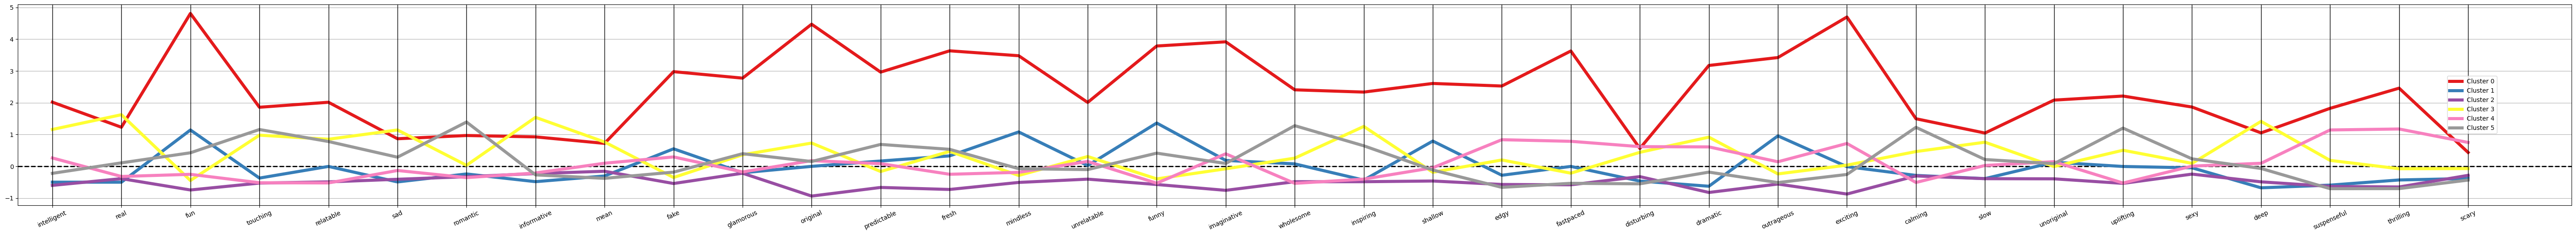

In [3]:
pd.options.display.max_columns = None

# Normalized distance
genre_norm = genre.apply(preprocessing.scale, axis=0)

# Cluster membership, CHANGE NUMBER OF CLUSTERS HERE
kmeans = KMeans(n_clusters=6, random_state=0).fit(genre_norm)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=genre_norm.columns)
pd.set_option('precision', 3)

centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]

fig = plt.figure(figsize=(20,6), dpi=100)
plt.xticks(rotation=25)
fig.subplots_adjust(right=3)
plt.axhline(y=0, color='black', linewidth=2, linestyle='dashed')
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Set1', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,36.5)
centroids

# 6 CLUSTERS NAMED + LIST OF CLUSTERED ATTRIBUTES

In [4]:
centroids = centroids.drop(['cluster'], axis=1)
centroids_transposed = centroids.T
centroids_transposed.columns = centroids_transposed.columns.astype(str)

# CREATES A LIST OF A RANGE OF THE NUMBER OF CLUSTERS, THEN COVERTED DATATYPES INTO STRINGS
s = []
for r in range(len(centroids)):
    s.append(str(r))

# MANUALLY NAMING CLUSTERS IN ORDER OF THEIR CLUSTER NUMBER
names = ["Romantic Drama","Action Thriller","???","Historical","Comedy","Fantasy/SciFi","Horror"]

# PRINT TOP 10 ATTRIBUTES THAT ARE OVER 0.7 FOR EACH CLUSTER
for a in s:
    print(names[int(a)])
    indv = centroids_transposed.sort_values(by=[a], ascending = False)
    indv = indv.loc[indv[a] > 0.7]
    print(indv[a].head(10))
    print('')

Romantic Drama
fun            4.808
exciting       4.697
original       4.470
imaginative    3.917
funny          3.784
fresh          3.633
fastpaced      3.628
mindless       3.479
outrageous     3.421
dramatic       3.172
Name: 0, dtype: float64

Action Thriller
funny         1.361
fun           1.143
mindless      1.081
outrageous    0.957
shallow       0.794
Name: 1, dtype: float64

???
Series([], Name: 2, dtype: float64)

Historical
real           1.623
informative    1.540
deep           1.413
inspiring      1.254
intelligent    1.159
sad            1.143
touching       0.979
dramatic       0.917
relatable      0.851
mean           0.765
Name: 3, dtype: float64

Comedy
thrilling      1.174
suspenseful    1.143
edgy           0.836
fastpaced      0.786
scary          0.750
exciting       0.718
Name: 4, dtype: float64

Fantasy/SciFi
romantic     1.393
wholesome    1.278
calming      1.226
uplifting    1.201
touching     1.157
relatable    0.780
Name: 5, dtype: float64



In [5]:
memb = pd.Series(kmeans.labels_, index=genre_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ''.join(str(item.index)))

0 :  Index(['1917', '21 Jump Street', 'American Pie 2',
       'Back to the Future Part II', 'Back to the Future Part III', 'Big',
       'Boo! A Madea Halloween', 'Cars', 'Charlie's Angels [2000]', 'Chicago',
       'Clueless', 'Crazy Rich Asians', 'Creed', 'Deadpool', 'Die Hard 2',
       'Django Unchained', 'Dreamgirls', 'Fantastic Four', 'Freaky Friday',
       'Furious 7', 'Ghostbusters II', 'Hot Tub Time Machine',
       'Jurassic Park III', 'Mulan [2020]', 'Rio', 'Superbad',
       'The Empire Strikes Back', 'WALL·E'],
      dtype='object', name='movie_name')
1 :  Index(['21 & Over', '22 Jump Street', '30 Minutes or Less',
       'A Bad Moms Christmas', 'A Chump at Oxford',
       'A Fantastic Fear of Everything', 'A Fish Called Wanda',
       'A Madea Christmas', 'A Madea Family Funeral',
       'A Million Ways to Die in the West',
       ...
       'Yes Man', 'Yogi Bear', 'You Don't Mess with the Zohan', 'Young Adult',
       'Young Frankenstein', 'Your Highness', 'Zombieland'

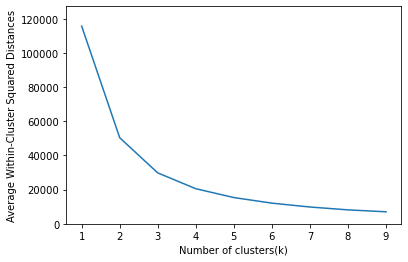

In [6]:
inertia = []
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(genre_norm)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 10), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()